In [1]:
!pip install -U --pre tensorflow=="2.2.0"

  Using cached https://files.pythonhosted.org/packages/3d/be/679ce5254a8c8d07470efb4a4c00345fae91f766e64f1c2aece8796d7218/tensorflow-2.2.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a4/f5/926ae53d6a226ec0fda5208e0e581cffed895ccc89e36ba76a8e60895b78/tensorflow_estimator-2.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1d/74/0a6fcb206dcc72a6da9a62dd81784bfdbff5fedb099982861dc2219014fb/tensorboard-2.2.2-py3-none-any.whl
ERROR: tf-models-official 2.3.0 has requirement tensorflow>=2.3.0, but you'll have tensorflow 2.2.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Using cached https://files.pythonhosted.org/packages/97/ae/0b08f53498417914f2274cc3b5576d2b83179b0cbb209457d0fde0152174/tensorflow-2.3.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e9/1b/6a420d7e6ba431cf3d51b2a5bfa06a958c4141e3189385963dc7f6fbffb6/tensorboard-2.3.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e9/ed/5853ec0ae380cba4588eab1524e18ece1583b65f7ae0e97321f5ff9dfd60/tensorflow_estimator-2.3.0-py2.py3-none-any.whl
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1577663 sha256=de80cc760a1b964f6d29cd26c90bb146fe0ff0ff6f9cffb26847a2e53481e3f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-xibn_7of/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-

# Load DOTA Data from Google Drive

Here I load the DOTA training/validation sets from Google Drive. In this example, the dota_data base path can be set to either `dota_data` for the full training/validation sets or `example` for a much smaller version (for testing purposes).

In [4]:
#Note: run command below will prompt your Google account permission
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

#Now test if the shared folder is in the right path in mounted gdrive
#The command below should show a sub-folder called dota-data/
!ls "gdrive/My Drive/object-detection-research"

# dota_base_path = 'gdrive/My Drive/object-detection-research/dota_data'
dota_base_path = 'gdrive/My Drive/object-detection-research/example'
verbose = True

Mounted at /content/gdrive
dota_data  dota.ipynb  eager_few_shot_od_training_tf2_colab.ipynb  example


In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
import json
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from typing import Generator, Tuple, List

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

from object_detection.dataset_tools.create_coco_tf_record \
  import _create_tf_record_from_coco_annotations as create_coco_tf_record

%matplotlib inline

#Utilities

Functions that we will use later...

In [33]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  image_np = np.array(image)

  if len(image_np.shape) == 2: # if grayscale, add RGB channels
    image_np = np.repeat(image_np[..., np.newaxis], 3, -1)
    print('Added channels to grayscale image. New shape is: ' + str(image_np.shape))

  return image_np.reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.3)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Construct Dictionaries

Here we use the annotations provided in the coco annotations folder to construct dictionaries of information for the images that we will use to in the following preprocessing steps.

Two dictionaries are constructed here:

  1. **images_dict**: maps the image id to information about that image. The information it stores is:

    1. image dimension information (as a tuple): (width, height)
    2. ground-truth boxes information (this is initially empty but is appended to later on in the code)

  2. **file_name_dict**: maps the file_name to its corresponding image id 

In [7]:
def construct_images_dict(annotations):
  """ Constructs a dictionary for the images that maps image ids to
  corresponding information about that image
  
  Args:
    A dictionary of annotations in the coco format

  Returns:
    A dictionary with...
      (1) image dimensions information: (width, height)
      (2) list of ground-truth HBB... empty initially: []
  """
  images_dict = {}
  image_info_list = train_annotations['images']
  for image in image_info_list:
    id = image['id']
    file_name = image['file_name']
    width = image['width']
    height = image['height']
    images_dict[id] = {}
    images_dict[id]['name'] = file_name
    images_dict[id]['dimensions'] = (width, height)
    images_dict[id]['windows'] = {} # will store sliding window info  for image here
  return images_dict

def map_file_name_to_id(annotations):
  """ Constructs a dictionary for the images that maps their file names
  to their corresponding ids
  
  Args:
    A dictionary of annotations in the coco format

  Returns:
    A dictionary that maps file_name -> image id
  """
  file_name_dict = {}
  image_info_list = train_annotations['images']
  for image in image_info_list:
    id = image['id']
    file_name = image['file_name']
    # file_name_dict[file_name] = id   # map file name -> id
    file_name_dict[id] = file_name   # map id -> file name
    print(file_name_dict)
  return file_name_dict


with open(dota_base_path + '/annotations/train.json') as json_file:
  train_annotations = json.load(json_file)

# construct dictionaries containing info about images
images_dict = construct_images_dict(train_annotations)
file_name_dict = map_file_name_to_id(train_annotations)

{1: 'P0706.png'}
{1: 'P0706.png', 2: 'P0770.png'}
{1: 'P0706.png', 2: 'P0770.png', 3: 'P1088.png'}
{1: 'P0706.png', 2: 'P0770.png', 3: 'P1088.png', 4: 'P1234.png'}
{1: 'P0706.png', 2: 'P0770.png', 3: 'P1088.png', 4: 'P1234.png', 5: 'P1888.png'}
{1: 'P0706.png', 2: 'P0770.png', 3: 'P1088.png', 4: 'P1234.png', 5: 'P1888.png', 6: 'P2598.png'}
{1: 'P0706.png', 2: 'P0770.png', 3: 'P1088.png', 4: 'P1234.png', 5: 'P1888.png', 6: 'P2598.png', 7: 'P2709.png'}


# DOTA data

Here we have a generator function for loading images from the training data. We have previously loaded the data from our Google Drive.

In [25]:
def get_images(image_dir: str) -> Generator[ np.ndarray, None, None ]:
  """ A generator for images given the image directory """
  image_names = os.listdir(image_dir) # get a list of the names of the training images
  print(image_names)
  num_images = len(image_names) # get the total number of training images
  # convert images to numpy arrays
  for image_name in image_names:
    image_path = os.path.join(image_dir, image_name)
    yield load_image_into_numpy_array(image_path)

train_image_dir = dota_base_path + '/train/images/'

# Prepare data for training

Here we use the images_dict constructed earlier and the coco annotations dictionary to prepare the data for the training step. This is where most of the preprocessing occurs.

In [9]:
# First, we use a sliding window to divide up images into smaller images
# We need to do this because the training process requires smaller images

def full_window(arr: np.ndarray) -> Generator[ Tuple[np.ndarray,int,int] , None, None]:
    yield (arr, 0, 0)

def get_windows(arr: np.ndarray, win_height: int, win_width: int,
        stride_vert: int, stride_horiz: int) -> Generator[ Tuple[np.ndarray,int,int,int,int] , None, None]:
    """
    Divides an image into (not necessarily disjoint) windows
    :param np.ndarray arr: The image to divide
    :param int win_height: The height in pixels of each window
    :param int win_width: The width in pixels of each window
    :param int stride_vert: How many pixels to move downward after finishing a row of windows
    :param int stride_horiz: How many pixels to move to the right after generating a window
    :rtype: Generator[ Tuple[np.ndarray,int,int] , None,None]
    :returns: The windows (one-by-one, so that you can loop over them in a for loop without them all being in memory)
    """
    (height, width, _) = arr.shape
    for y in range(0, height, stride_vert):
      ymin = y
      new_height = y + win_height
      pad_y = 0
      if y + win_height - 1 >= height: # need to pad the y axis
        new_height = height
        pad_y = y + win_height - height
      for x in range(0, width, stride_horiz):
        xmin = x
        new_width = x + win_width
        pad_x = 0
        if x + win_width - 1 >= width: # need to pad the x axis
          new_width = width
          pad_x = x + win_width - width
        win = arr[y: new_height, x: new_width]
        # pad the array in the top and right sides of the image to get desired shape
        win = np.pad(win, ((pad_y, 0), (0, pad_x), (0,0)), mode='constant', constant_values=3)
        yield (win, xmin, ymin, new_width, new_height)

win_height = 1024
win_width  = 1024
win_stride_vert  = 512
win_stride_horiz = 512

win_set = (win_height, win_width, win_stride_vert, win_stride_horiz)

# image['dimensions'] = (width,height)
# [ymin, xmin, ymax, xmax]
# divide images into windows and...
# construct train_images_np - should be a list of all the windows of all the images
train_images_np = [] # the sliding windows of the images
for index, image_np in enumerate(get_images(train_image_dir)):
  image_dict = images_dict[index+1]
  # divide image into windows of size win_height * win_width 
  # and add to dictionary corresponding to that image
  windows = {}
  for win_index, (window, xmin, ymin, xmax, ymax) in enumerate(get_windows(image_np, *win_set)):
    if verbose: print('NEW WINDOW with dimensions ' + str(window.shape))
    window_dict = {}
    window_dict['window'] = window
    window_dict['xmin'] = xmin
    window_dict['ymin'] = ymin
    window_dict['xmax'] = xmax
    window_dict['ymax'] = ymax
    window_dict['dimensions'] = (xmax - xmin, ymax - ymin)
    window_dict['boxes'] = []
    windows[len(train_images_np)] = window_dict # 0,1,2,3...# of windows - 1
    train_images_np.append(window)
  
  images_dict[index+1]['num windows'] = len(windows)
  images_dict[index+1]['windows'] = windows


P0706.png
gdrive/My Drive/object-detection-research/example/train/images/P0706.png -> 1
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
P0770.png
gdrive/My Drive/object-detection-research/example/train/images/P0770.png -> 2
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WINDOW with dimensions (1024, 1024, 3)
NEW WIN

In [10]:
def get_window_ids(box: List, image_dict: dict) -> List:
  """ Maps an annotation box to its corresponding window_ids
  Previously associated with the image_id

  Note that there could be multiple window ids associated with one annotation
  box because of the stride on the window slider
  """
  xmin,ymin,xmax,ymax = box
  # window has info on xmin, ymin, width, and height
  window_ids = []
  for window_id, window in image_dict['windows'].items():
    win_xmin = window['xmin']
    win_xmax = window['xmax']
    win_ymin = window['ymin']
    win_ymax = window['ymax']
    if xmin >= win_xmin and xmax <= win_xmax:
      if ymin >= win_ymin and ymax <= win_ymax:
        window_ids.append(window_id)

  return window_ids
    

num_successes = 0
num_failures  = 0

# Get annotated boxes for each image window
annotations_dict = train_annotations['annotations']
for annotation in annotations_dict:
  # **** DOTA annotation info ****
  # Two forms of annotation exist in this annotations dictionary
  #   (1) Arbitrary BB: {(xi,yi) for i = 1,2,3,4}
  #   (2) HBB: [xmin, ymin, width, height]
  # We use (2) here because it more closely fits the original BB format
  hbb = annotation['bbox']
  # calculate HBB in new format
  xmin = hbb[0]
  ymin = hbb[1]
  xmax = xmin + hbb[2]
  ymax = ymin + hbb[3]
  # get corresponding window id associated with the annotated box
  image_id = annotation['image_id']
  window_ids = get_window_ids([xmin,ymin,xmax,ymax], images_dict[image_id])
  if not window_ids:
    num_failures += 1
    print('Couldn\'t find window for annotation ' + str([xmin,ymin,xmax,ymax]) + ' in image ' + images_dict[image_id]['name'])
  else:
    num_successes += 1
    for window_id in window_ids:
      (width, height) = images_dict[image_id]['windows'][window_id]['dimensions']
      # normalize dimensions
      xmin, xmax = xmin / width, xmax / width
      ymin, ymax = ymin / height, ymax / height
      # print('[' + str(ymin) + ', ' + str(xmin) + ', ' + str(ymax) + ', ' + str(xmax) + ']')
      images_dict[image_id]['windows'][window_id]['boxes'].append([ymin, xmin, ymax, xmax])

print('Percent of annotations preserved: ' + str(round((num_successes / (num_successes + num_failures))*100,2)) + '%')


# construct gt_boxes array of numpy lists of boxes for each window in each image
gt_boxes = [None] * len(train_images_np)
no_annotation_ids = {}
for image_id in images_dict:
  for win_id, window in images_dict[image_id]['windows'].items():
    gt_boxes[win_id] = np.array(window['boxes'], dtype=np.float32)
    if not window['boxes']:
      no_annotation_ids[win_id] = ''

# print(no_annotation_ids)

# print(gt_boxes)

# remove windows and their corresponding "boxes" in which there are no annotations
# from train_images_np and gt_boxes
# the boxes array will be empty in these
old_train_images_np = train_images_np.copy()
old_gt_boxes = gt_boxes.copy()
train_images_np = []
gt_boxes = []
for index,_ in enumerate(old_train_images_np):
  if not index in no_annotation_ids:
    train_images_np.append(old_train_images_np[index])
    gt_boxes.append(old_gt_boxes[index])

# print(gt_boxes)

# construct category index in correct format
category_index  = {}
for category in train_annotations['categories']:
  category_index[category['id']] = {
      'id': category['id'],
      'name': category['name']
  }

num_classes = len(category_index)

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  # print(gt_box_np)
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

# print(train_image_tensors)
# print(gt_classes_one_hot_tensors)
# print(gt_box_tensors)

Couldn't find window for annotation [1054, 1011, 1112, 1062] in image P0706.png
Couldn't find window for annotation [3926, 721, 4001, 785] in image P1234.png
Couldn't find window for annotation [1289, 255, 2129, 1798] in image P2598.png
Percent of annotations preserved: 99.7%
Done prepping data.


# Visualize as a sanity check

This shows the images and their corresponding annotated bounding boxes just to make sure we are doing this correctly.

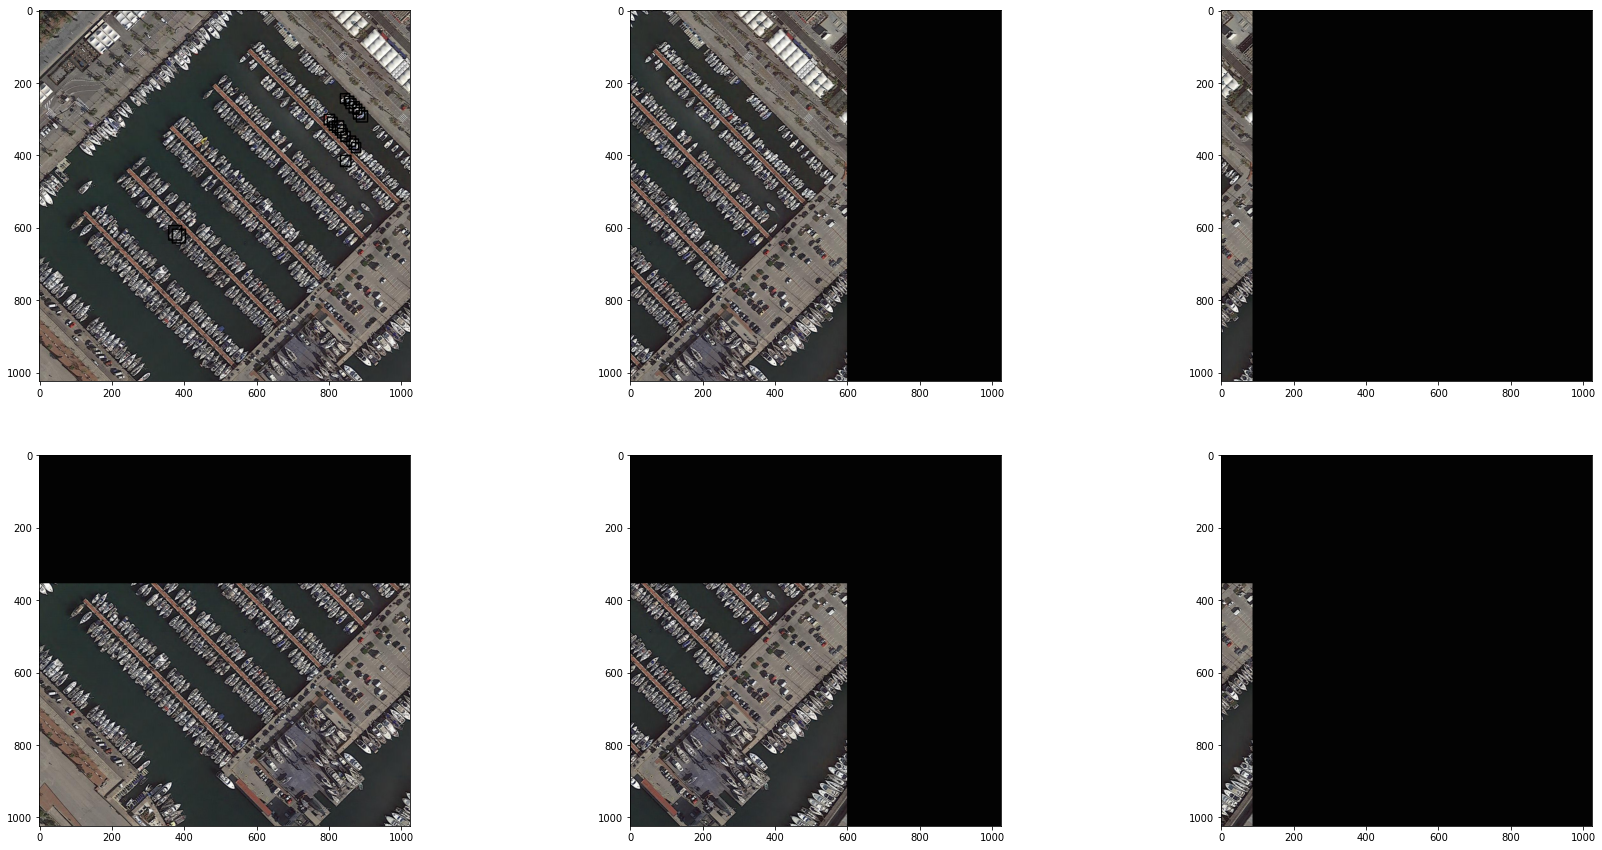

In [11]:
# dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
dummy_scores = None # give boxes no score

plt.figure(figsize=(30, 15))
# print(gt_boxes)
# print(category_index)
# print(dummy_scores)
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, 
      category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [12]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-09-15 19:10:07--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   260MB/s    in 0.9s    

2020-09-15 19:10:08 (260 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [15]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 15
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 1024, 1024, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop

In [16]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 30

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  # print(gt_boxes_list)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 30, loss=3.6476517
batch 10 of 30, loss=50.906036
batch 20 of 30, loss=61.708553
Done fine-tuning!


# Load test images and run inference with new model!

['P0003.png', 'P0557.png', 'P0910.png', 'P0949.png', 'P1432.png', 'P2168.png', 'P2733.png']
{'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[0.8627331 , 0.02635987, 0.8627626 , 0.02639496],
        [0.493548  , 0.77982396, 1.        , 1.        ],
        [0.64983207, 0.5021945 , 0.8253985 , 0.802228  ],
        [0.6317878 , 0.9245995 , 0.69103837, 1.        ],
        [0.21934491, 0.488132  , 0.35273522, 0.54672587],
        [0.34416705, 0.        , 1.        , 1.        ],
        [0.22120717, 0.46037978, 0.35057184, 0.51781434],
        [0.80705243, 0.23796052, 0.83831686, 0.3152359 ],
        [0.3314062 , 0.26366276, 0.40000108, 0.28636575],
        [0.49974823, 0.        , 1.        , 1.        ],
        [0.1970201 , 0.4819027 , 0.32715493, 0.5418494 ],
        [0.7474711 , 0.8668479 , 1.        , 1.        ],
        [0.9172087 , 0.16298553, 0.9281318 , 0.19399443],
        [0.1967957 , 0.23212701, 1.        , 1.        ],
        [0.493548  , 0.

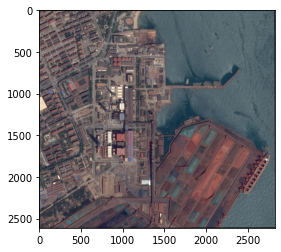

In [36]:
test_image_dir = dota_base_path + '/validation/images/'
test_images_np = []

for test_image_np in get_images(test_image_dir):
  test_images_np.append(np.expand_dims(test_image_np, axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  print(detections)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20))